In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
import scipy.linalg

import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

from scipy import sparse
from scipy import stats

import numpy as np
import scipy.sparse

import matplotlib.pyplot as plt

from numpy import linalg as LA
import time 

# Pre-Processing

# Frank-Wolfe - standard algorithm

- Should we feed $\delta$ to the FW algorithm or should it be defined based on the dimensions of the data?
- Which is the correct objective function?
- Initialize with random matrix of integers from 1 to 5 or with zeros matrix?

In [4]:
def FW_objective_function(diff_vec):
    return 0.5*(np.power(diff_vec,2).sum())
    #return 0.5 * np.linalg.norm(diff_vec, 2)**2

def FrankWolfe(X, objective_function, delta, printing_res = True, Z_init = None, max_iter = 150, patience = 1e-3):
    '''
    :param X: sparse matrix with ratings and 'empty values', rows - users, columns - books.
    :param objective_function: objective function that we would like to minimize with FW
    :param Z_init: In case we want to initialize Z with a known matrix, if not given Z_init will be a zeros matrix
    :param max_iter: max number of iterations for the method
    :param patience: once reached this tolerance provide the result
    :return: Z: matrix of predicted ratings - it should be like X but with no 'empty values'
            accuracy: difference between original values (X) and predicted ones (Z)
    '''
    res_list = []

    # Get X indexes for not empty values
    idx_ratings = np.argwhere(X != 0)
    #idx_ratings = np.argwhere(~np.isnan(X))
    idx_rows = idx_ratings[:,0]
    idx_cols = idx_ratings[:,1]

    # Initialize Z -- think about a good init
    if Z_init is not None:
        Z = Z_init
    else:
        #Z = np.random.randint(1, 6, size=X.shape)
        #Z = Z.astype(float)
        Z = np.random.uniform(low = 0.01, high = 1, size = X.shape)

    # Create vectors with the not empty features of the sparse matrix
    X_rated = X[idx_rows, idx_cols]
    Z_rated = Z[idx_rows, idx_cols]
    diff_vec = Z_rated - X_rated
    flat = np.array(diff_vec)[0]

    # choose an appropriate delta
    delta = delta

    diff_err = patience + 1
    err = objective_function(diff_vec)
    it = 0
    while (diff_err > patience) and (it < max_iter):

        # Gradient
        grad = sparse.csr_matrix((flat, (idx_rows, idx_cols)))

        # SVD
        u_max, s_max, v_max = sparse.linalg.svds(grad, k = 1, which='LM')   # Compute k = 1 singular values, starting from the largest (which = 'LM')

        # Update
        Zk_tilde = -delta*np.outer(u_max,v_max)     # Zk_tilde in the theory
        #Zk_tilde = np.random.uniform(size = Z.shape)
        #alpha - as studied in class
        alpha_k = 2/(it+2)
        Z = (1-alpha_k)*Z + alpha_k*Zk_tilde
        # Error
        diff_vec = Z[idx_rows, idx_cols] - X_rated
        flat = np.array(diff_vec)[0]

        new_err = objective_function(diff_vec)

        # Improvement at this iteration
        diff_err = np.abs(err - new_err)
        err = new_err

        if printing_res == True:
            if it == 1 or it % 10 == 0:
                print('Iteration:', it, 'Err:', err, 'Diff err:', diff_err, 'Z rank: ',np.linalg.matrix_rank(Z), 'Z_tilde rank: ', sparse.csgraph.structural_rank(Zk_tilde) )

        # Count iteration
        it += 1

        res_list.append(err)
        
    return Z, Zk_tilde, err, res_list

We build a smaller matrix for testing the FW alg, then we will apply it to our data

In [166]:
n = 200
m = 200
r = 10
rho = 0.10
SNR = 5
delta = 3.75

# taking data
U = scipy.sparse.random(m, r, density=0.1, format='csr', data_rvs=None)
V = scipy.sparse.random(r, n, density=0.1, format='csr', data_rvs=None)
E = scipy.sparse.random(m, n, density=0.1, format='csr', data_rvs=None)

VT = V.transpose(copy=True)

UVT = U*V
#print(UVT. shape)

w1 = 1/(scipy.sparse.linalg.norm(UVT, ord='fro'))

w2 = 1/(SNR*scipy.sparse.linalg.norm(E, ord='fro'))

#Finally observed data matrix is: 

X = w1*UVT + w2*E

idx_ratings = np.argwhere(X != 0)
#idx_ratings = np.argwhere(~np.isnan(X))
idx_rows = idx_ratings[:,0]
idx_cols = idx_ratings[:,1]


Z = np.random.uniform(low = 0.01, high = 1, size = X.shape)

# Create vectors with the not empty features of the sparse matrix
X_rated = X[idx_rows, idx_cols]
Z_rated = Z[idx_rows, idx_cols]
diff_vec = Z_rated - X_rated


print(diff_vec.shape)
flat = np.array(diff_vec)[0]
print(flat.shape)
print(idx_rows.shape)
print(idx_cols.shape)

print(flat)
print(np.linalg.matrix_rank(X))

print(X.max(), X.min())

grad = sparse.csr_matrix((flat, (idx_rows, idx_cols)))

(1, 7425)
(7425,)
(7425,)
(7425,)
[0.91103694 0.81319445 0.96501526 ... 0.54827684 0.4390021  0.53228047]
1
0.08418816681601686 0.0


<string>:6: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.


In [88]:
pred_ratings, loss, third, ff = FrankWolfe(X, FW_objective_function, delta = 10, max_iter=25, patience=1e-7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: SparseEfficiencyWarning: Input matrix should be in CSC, CSR, or COO matrix format


Iteration: 0 Err: 23.76231691524653 Diff err: 4937.825449856199 Z rank:  1 Z_tilde rank:  400
Iteration: 1 Err: 4.045499811594704 Diff err: 19.716817103651827 Z rank:  2 Z_tilde rank:  400
Iteration: 10 Err: 0.9666582665940376 Diff err: 0.2729696118834458 Z rank:  11 Z_tilde rank:  400
Iteration: 20 Err: 0.3878204383755473 Diff err: 0.008775661954487923 Z rank:  21 Z_tilde rank:  400


In [ ]:
#pred_ratings*5

#### Our data prediction

In [167]:
pred_ratings, update_Z, loss, res_listFW = FrankWolfe(X, FW_objective_function, delta = 32000, max_iter=100, patience=1e-5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: SparseEfficiencyWarning: Input matrix should be in CSC, CSR, or COO matrix format


Iteration: 0 Err: 203212882.4222679 Diff err: 203211643.65152794 Z rank:  1 Z_tilde rank:  200
Iteration: 1 Err: 62841792.80300829 Diff err: 140371089.61925963 Z rank:  2 Z_tilde rank:  200
Iteration: 10 Err: 4005616.4347545668 Diff err: 497969.01789768273 Z rank:  11 Z_tilde rank:  200
Iteration: 20 Err: 1127548.1314056655 Diff err: 70657.56012711907 Z rank:  18 Z_tilde rank:  200
Iteration: 30 Err: 522344.1354961496 Diff err: 21688.524324718106 Z rank:  20 Z_tilde rank:  200
Iteration: 40 Err: 300105.36260788655 Diff err: 9224.155958480958 Z rank:  21 Z_tilde rank:  200
Iteration: 50 Err: 194557.75371787895 Diff err: 4695.15126778296 Z rank:  22 Z_tilde rank:  200
Iteration: 60 Err: 136288.43648182706 Diff err: 2675.2997084757662 Z rank:  23 Z_tilde rank:  200
Iteration: 70 Err: 100760.19633465409 Diff err: 1645.5714684170234 Z rank:  23 Z_tilde rank:  200
Iteration: 80 Err: 77512.02815839922 Diff err: 1068.7387341593421 Z rank:  23 Z_tilde rank:  200
Iteration: 90 Err: 61473.2898209

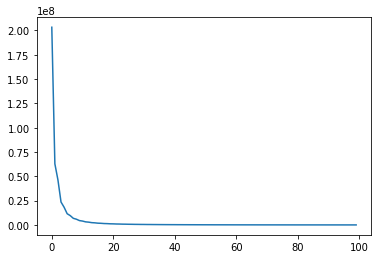

In [168]:
plt.plot(res_listFW)

In [169]:
loss

50446.58862525489

In [171]:
pred_reg = (pred_ratings*6)-1

print(np.linalg.matrix_rank(pred_reg, tol = -10))
print(pred_reg.astype(int))

200
[[108   0   0 ...   0   0   0]
 [ -1  -1  -1 ...  -1  -1  -1]
 [ -1  -1  -1 ...  -1  -1  -1]
 ...
 [ -1  -1  -1 ...  -1  -1  -1]
 [ -1  -1  -1 ...  -1  -1  -1]
 [ 65   0   0 ...   0   0   0]]


# Frank-Wolfe In-face

In [172]:
time_out = time.process_time() + 5  

In [12]:
def FW_objective_function(diff_vec):
    return 0.5*(np.power(diff_vec,2).sum())
    #return 0.5 * np.linalg.norm(diff_vec, 2)**2

In [173]:
def alpha_binary_search(Zk, Dk, delta, max_value = 1, min_value = 0, tol = 0.15):
        
    #Inizialization
    
    best_alpha = (max_value - min_value) / 2
    
    testing_matrix = Zk + best_alpha * Dk
      
    testing_mat_nuclear_norm = LA.norm(testing_matrix, ord = 'nuc')
    
    #Binary Search
 
    while testing_mat_nuclear_norm <= delta and (max_value - min_value) >= tol:
        
        min_value = best_alpha
        
        best_alpha = (max_value - min_value) / 2

        testing_matrix = Zk + best_alpha * Dk
    
        testing_mat_nuclear_norm = LA.norm(testing_matrix, ord = 'nuc')    
        
    return best_alpha

In [284]:
def FW_inface(X, objective_function, delta, gamma1 = 0, gamma2 = 1, THRES = 0.001, Z_init = None, max_iter=150, patience=1e-3, printing = True):
    '''
    :param X: sparse matrix with ratings and 'empty values', rows - users, columns - books.
    :param objective_function: objective function that we would like to minimize with FW.
    :param Z_init: In case we want to initialize Z with a known matrix, if not given Z_init will be a zeros matrix.
    :param max_iter: max number of iterations for the method.
    :param patience: once reached this tolerance provide the result.
    :return: Z: matrix of predicted ratings - it should be like X but with no 'empty values'
            loss: difference between original values (X) and predicted ones (Z).
    '''

    # Get X indexes for not empty values
    idx_ratings = np.argwhere(X != 0)
    #idx_ratings = np.argwhere(~np.isnan(X))
    idx_rows = idx_ratings[:,0]
    idx_cols = idx_ratings[:,1]

    # choose an appropriate delta

    # Initialize Z_{-1}
    if Z_init is not None:
        Z = Z_init
    else:
        Z = np.zeros(X.shape)

    # Create vectors with the not empty features of the sparse matrix
    X_rated = X[idx_rows, idx_cols]
    Z_rated = Z[idx_rows, idx_cols]
    diff_vec = Z_rated - X_rated
    diff_vec = np.array(diff_vec)[0]

    # Initial gradient and Z0
    grad = sparse.csr_matrix((diff_vec, (idx_rows, idx_cols)))
    u_max, s_max, v_max = sparse.linalg.svds(grad, k = 1, which='LM')
    Zk = -delta*np.outer(u_max,v_max)
    Z_rated = Zk[idx_rows, idx_cols]

    print('Initial Zk Rank: ', LA.matrix_rank(Zk))

    # Initialize lower bound on the optimal objective function (f*)
    diff_vec = Z_rated - X_rated
    new_low_bound = np.max((objective_function(diff_vec) + np.multiply(diff_vec,Z_rated)), 0).sum()
    #new_low_bound = 0 #used 0 otherwise the other new_low_bound was too high!

    # Set L and D constants
    L = 1
    D = 2*delta

    # Compute first iteration thin SVD
    #grad = sparse.csr_matrix((diff_vec, (idx_rows, idx_cols)))
    r_grad = LA.matrix_rank(diff_vec)   # Compute rank of the gradient sparse matrix to find thin SVD size
    # U_thin, D_thin, Vh_thin = sparse.linalg.svds(grad, k = r_grad, which = 'LM')   # Compute k = rank singular values # replaced r_grad with 1
    # U_app, D_app, Vh_app = sparse.linalg.svds(grad, k = 1, which='SM')
    U_thin, D_thin, Vh_thin = LA.svd(grad.toarray())
    D_thin = D_thin.T

    # Additional needed parameters
    diff_objective = patience + 1
    objective = objective_function(diff_vec)
    it = 0
    res_list = [objective]

    while (diff_objective > patience) and (it < max_iter):

        # Lower bound update
        low_bound = new_low_bound

        # In-face direction with the away step strategy: two calculations depending of where Z lies within the feasible set
        if D_thin.sum() <= delta: # Z in border (sum of singular values == radious of feasible set)
            G = 0.5 * (Vh_thin.dot(grad.T.dot(U_thin)) + U_thin.T.dot(grad.dot(Vh_thin.T)))

            ''' WE NEEDED NOT ONLY THE SMALLEST EIGENVALUE, BUT THE EIGENVECOTR ASSOCIATED WITH THE SMALLEST VALUE
            u = sparse.linalg.eigs(G, k = 1, which = 'SM')#unitary eigenvector corresponding to smallest eigenvalue of G
            '''

            print('Zk in border!')
            eigvalues, eigvectors = LA.eig(G)               #find the eigenvalues
            min_eig = np.argmin(eigvalues)      #find the index of the smallest eigenvalue
            u = eigvectors[:,min_eig]          #take the eigenvector corresponding to the smallest eigenvalue
            M = np.outer(u,u.T)
            Zk_tilde = delta*U_thin.dot(M).dot(Vh_thin)
            Dk = Zk - Zk_tilde
            alpha_B = 0.5

            ''' DOESN'T WORK <-- To solve!
            alpha_B = scipy.linalg.inv(delta*u.T.dot(scipy.linalg.inv(Dk)).dot(u)-1)
            '''

        else: #inside

            idx_max_s = np.argmax(D_thin)
            Zk_tilde = delta*np.outer(U_thin[idx_max_s,:],Vh_thin[idx_max_s,:])
            Dk = Zk - Zk_tilde
            #BINARY SEARCH (xd)
            '''
            alpha_B = alpha_binary_search(Zk, 
                                          Dk, 
                                          delta) 
            '''
            alpha_B = 0.5

        nuclear_norm = D_thin.sum()
        U = nuclear_norm * D_thin # standardize the simplex
        r = D_thin.shape[0]     # added the index so it could be compared to a number
        no_obs = idx_rows.shape[0] # <-- is this thing useless? - Gabri
        # THRES = 0.001

        #print('Nuclear Norm:  ' + str(nuclear_norm))
        
        #if abs(delta - nuclear_norm) < THRES and r > 1:
        Z_B = Zk + alpha_B * Dk
        diff_vec_B = Z_B[idx_rows, idx_cols] - X_rated
        diff_vec_B = np.array(diff_vec_B)[0].sum()
        beta = alpha_B / 5 # FIND A GOOD VALUE -- a binary search is also suggested by the paper xdd

        Z_A = Zk + beta * Dk
        diff_vec_A = Z_A[idx_rows, idx_cols] - X_rated
        diff_vec_A = np.array(diff_vec_A)[0].sum()

        '''

        print('TESTING')
        print('Dk: ', Dk[1,:10], '\nZk: ', Zk[1,:10], '\nalpha_B: ', alpha_B)  


        

        print('First Condition: ' + str(1/(objective_function(diff_vec_B)-low_bound)) + '   vs   Second Condition: ' + str(1/(objective-low_bound)+gamma1/(2*L*D**2)))
        print('Elif:')
        print('First Condition: ' + str(1/(objective_function(diff_vec_A)-low_bound)) + '   vs   Second Condition: ' + str(1/(objective-low_bound)+gamma2/(2*L*D**2)))

        

        print('Low Bound:' + str(low_bound))
        print('1 / (Objective - Low Bound): ' + str(1/(objective-low_bound)))

        '''

        # if abs(delta - nuclear_norm) < THRES and r > 1:
        if 1/(objective_function(diff_vec_B)-low_bound) >= (1/(objective-low_bound)+gamma1/(2*L*D**2)):

          # 1. Move to a lower dimensional face
          print('Went to a lower-dimensional face')
          Zk = Z_B

        elif 1/(objective_function(diff_vec_A)-low_bound) >= (1/(objective-low_bound)+gamma2/(2*L*D**2)):

          # 2. Stay in the current face
          print('Stay in the current face')
          Zk = Z_A

          # else:
          #   raise 'Error'

        else:

          # 3. Do a regular FW step and update the lower bound
          print('Do regular FW step')
          
          #Zk update
          idx_max_s = np.argmax(D_thin)
          Zk_tilde = -delta*np.outer(U_thin[idx_max_s,:],Vh_thin[:,idx_max_s]) # Am i selecting right the vectors??
          alpha_k = 2/(it+2)
          Zk = (1-alpha_k)*Z + alpha_k * Zk_tilde

          #print('Zk FW step: ', Zk[1,:10])

          # Lower bound update
          direction_vec = Zk_tilde.flatten() - Zk.flatten()

          grad = grad.toarray() # this method converts the sparse matrix into a numpy array!

          wolfe_gap = grad.T.flatten() * direction_vec #added the flatten otherwise you can't do the operation
          B_w = objective + wolfe_gap.sum()
          #new_low_bound = np.max(low_bound, B_w)   # gave problems during the execution: wanted both numbers as integers??

          ''' TRIED THIS INSTEAD '''
          if low_bound.sum() >= B_w:
            new_low_bound = low_bound
          else:
            new_low_bound = B_w

        # Loss
        diff_vec = Zk[idx_rows, idx_cols] - X_rated
        diff_vec = np.array(diff_vec)[0]
        new_objective = objective_function(diff_vec)

        # Improvement at this iteration
        diff_objective = np.abs(objective - new_objective)
        objective = new_objective

        # Gradient
        grad = sparse.csr_matrix((diff_vec, (idx_rows, idx_cols)))

        # Thin SVD
        r_grad = LA.matrix_rank(grad)   # Compute rank of the gradient sparse matrix to find thin SVD size
        #U_thin, D_thin, Vh_thin = sparse.linalg.svds(grad, k = 1, which='LM')   # Compute k = rank singular values # replaced r_grad with 1
        U_thin, D_thin, Vh_thin = LA.svd(grad.toarray())
        D_thin = D_thin.T

        # Count iteration
        it += 1

        res_list.append(objective)

        if printing == True:
          if it % 5 == 0 or it == 1:
            print(D_thin.sum())
            print('Iteration: ', it, 'f(Z_k): ', objective, 'f(Z_{k-1}) - f(Z_k): ', diff_objective, ' Rank of Zk: ', LA.matrix_rank(Zk))
            print(''' ''')

    return Z, objective, it, res_list

In [283]:
pred_ratings, loss, it, res_listInFW = FW_inface(X, FW_objective_function, gamma1 = 0, gamma2 = 1, delta = 15, THRES = 10000, max_iter = 100, patience = 0.0001, printing = True)

Initial Zk Rank:  1
Zk in border!
Do regular FW step
47.72894710715357
Iteration:  1 f(Z_k):  24.581787116251185 f(Z_{k-1}) - f(Z_k):  34.35482625542026  Rank of Zk:  1
 
Do regular FW step
Do regular FW step
Zk in border!
Do regular FW step


<string>:6: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.


Zk in border!
Do regular FW step
9.837974982804212
Iteration:  5 f(Z_k):  11.495483397828567 f(Z_{k-1}) - f(Z_k):  0.10031968639264655  Rank of Zk:  1
 
Zk in border!
Do regular FW step
Zk in border!
Do regular FW step
Zk in border!
Do regular FW step
Zk in border!
Do regular FW step
Zk in border!
Do regular FW step
7.786418223877986
Iteration:  10 f(Z_k):  4.222729505979625 f(Z_{k-1}) - f(Z_k):  0.5591515654792829  Rank of Zk:  1
 
Zk in border!
Do regular FW step
Zk in border!
Do regular FW step
Zk in border!
Do regular FW step
Zk in border!
Do regular FW step
Zk in border!
Do regular FW step
6.917799511949752
Iteration:  15 f(Z_k):  2.2156507684978806 f(Z_{k-1}) - f(Z_k):  0.34082060069897047  Rank of Zk:  1
 
Zk in border!
Do regular FW step
Zk in border!
Do regular FW step
Zk in border!
Do regular FW step
Zk in border!
Do regular FW step
Zk in border!
Do regular FW step
6.508054107533892
Iteration:  20 f(Z_k):  1.5638109442914951 f(Z_{k-1}) - f(Z_k):  0.041883674356942846  Rank of

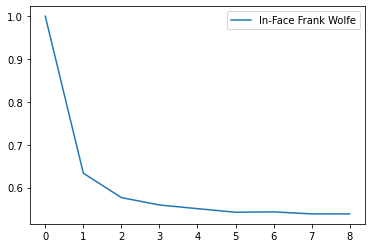

In [275]:
# plt.plot(res_listFW, label = 'Frank Wolfe')
plt.plot(res_listInFW, label = 'In-Face Frank Wolfe')
plt.legend()
plt.show()

# Goodreads DataSet

## Data Importing

In [ ]:
path = 'goodreads_cleaned.csv'
#path = 'DATA/goodreads_cleaned.csv'

In [ ]:
df = pd.read_csv(path, sep = ";")
df

,user_id,book_id,rating
0,8842281e1d1347389f2ab93d60773d4d,18245960,5
1,8842281e1d1347389f2ab93d60773d4d,16981,3
2,8842281e1d1347389f2ab93d60773d4d,28684704,3
3,8842281e1d1347389f2ab93d60773d4d,27161156,0
4,8842281e1d1347389f2ab93d60773d4d,25884323,4
...,...,...,...
899995,b9450d1c1f97f891c392b1105959b56e,11832081,3
899996,b9450d1c1f97f891c392b1105959b56e,16095092,3
899997,b9450d1c1f97f891c392b1105959b56e,8430896,4
899998,b9450d1c1f97f891c392b1105959b56e,12275680,4


## Data Exploration

In [ ]:
df.user_id.value_counts().describe()

count    12188.000000
mean        73.843124
std        103.860677
min          1.000000
25%         14.000000
50%         37.000000
75%         92.000000
max       1815.000000
Name: user_id, dtype: float64

In [ ]:
df.book_id.value_counts().describe()

count    25474.000000
mean        35.330141
std         67.222413
min          1.000000
25%         10.000000
50%         17.000000
75%         34.000000
max       1734.000000
Name: book_id, dtype: float64

## Data Cleaning

In [ ]:
df['book_id_count'] = df.groupby('book_id')['book_id'].transform('count')
df['user_id_count'] = df.groupby('user_id')['user_id'].transform('count')

In [ ]:
book_quantile = 0.95
user_quantile = 0.9

df = df.loc[(df.book_id_count >= df.book_id.value_counts().quantile(book_quantile)) & (df.user_id_count >= df.user_id.value_counts().quantile(user_quantile)),:]

In [ ]:
df.shape

(114041, 5)

## Data Pivoting

In [ ]:
df = pd.pivot_table(df, columns="book_id", index="user_id", values="rating")
df.head(10)

book_id,1,2,3,5,6,11,34,830,865,890,902,930,960,968,1103,1232,1617,1618,1622,1845,1885,1934,1953,2156,2165,2187,2493,2526,2623,2657,2744,2839,2998,3431,3473,3636,3682,4214,4381,4407,4588,4671,4929,4981,5043,5107,5129,5297,5364,5470,...,28374007,28449207,28458598,28477789,28588345,28597587,28678119,28686840,28763485,28862528,28954189,28962906,29008738,29056083,29069989,29236299,29237211,29283884,29367958,29385546,29396738,29519514,29519517,29541818,29610595,29772863,29780253,29868610,29939230,29939390,29991719,30075802,30095464,30117284,30226723,30253864,30256248,30312891,30555488,30653853,30724132,31140847,31450852,31451174,31931941,32075662,32075671,32571395,33232571,35247769
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00238d8a4c276c47f5d5e242f54a8f28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
002a023d3de233b4bd3ec4fc3e9c581a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
006f552534b15a7358a125f7505e0eea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
009235f414f42cfd0f76282f6aefe6c1,NaN,NaN,5.0,5.0,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN
009a47e49c0dc6e84d1c5e0eb4cdf7f6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00b5b129cc3cfa6511418cce1cec54ab,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01001347e5bab7241212a0a6910260f8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0102db8db2097cd4482ebc20b7b2d5be,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,N

In [ ]:
df.shape

(1218, 1276)

## Convert to an array to work with the matrix

In [ ]:
df.reset_index(drop=True)
df

book_id,1,2,3,5,6,11,34,830,865,890,902,930,960,968,1103,1232,1617,1618,1622,1845,1885,1934,1953,2156,2165,2187,2493,2526,2623,2657,2744,2839,2998,3431,3473,3636,3682,4214,4381,4407,4588,4671,4929,4981,5043,5107,5129,5297,5364,5470,...,28374007,28449207,28458598,28477789,28588345,28597587,28678119,28686840,28763485,28862528,28954189,28962906,29008738,29056083,29069989,29236299,29237211,29283884,29367958,29385546,29396738,29519514,29519517,29541818,29610595,29772863,29780253,29868610,29939230,29939390,29991719,30075802,30095464,30117284,30226723,30253864,30256248,30312891,30555488,30653853,30724132,31140847,31450852,31451174,31931941,32075662,32075671,32571395,33232571,35247769
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00238d8a4c276c47f5d5e242f54a8f28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
002a023d3de233b4bd3ec4fc3e9c581a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
006f552534b15a7358a125f7505e0eea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
009235f414f42cfd0f76282f6aefe6c1,NaN,NaN,5.0,5.0,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN
009a47e49c0dc6e84d1c5e0eb4cdf7f6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffbf525357e96614c4b9ee613aa95caa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ffd6c966d94d3d06c8cc4480536082b4,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
data_matrix = df.to_numpy(na_value=np.nan)
print(data_matrix)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan  5. nan ...  3. nan nan]]


In [ ]:
# Check how to get the index of not empty values
idx = np.argwhere(~np.isnan(data_matrix))
print(idx)

[[   0   65]
 [   0   79]
 [   0  204]
 ...
 [1217 1223]
 [1217 1236]
 [1217 1273]]


In [ ]:
np.unique(data_matrix[idx[:,0], idx[:,1]])

array([0., 1., 2., 3., 4., 5.])

# Tuned Model



In [ ]:
def FW_objective_function(diff_vec):
    return 0.5*(np.power(diff_vec,2).sum())
    #return 0.5 * np.linalg.norm(diff_vec, 2)**2
    
def alpha_binary_search(Zk, Dk, delta, max_value = 1, min_value = 0, tol = 0.3):
        
    #Inizialization
    
    best_alpha = (max_value - min_value) / 2
    
    testing_matrix = Zk + best_alpha * Dk

    sentinel = False

    while time.process_time() <= time_out:
      
      testing_mat_nuclear_norm = LA.norm(testing_matrix, ord = 'nuc')

      sentinel = True
    
    #Binary Search

    if sentinel == True:
    
      while testing_mat_nuclear_norm <= delta and (max_value - min_value) >= tol and time.process_time() <= time_out:
          
          min_value = best_alpha
          
          best_alpha = (max_value - min_value) / 2

          testing_matrix = Zk + best_alpha * Dk
      
          testing_mat_nuclear_norm = LA.norm(testing_matrix, ord = 'nuc')     
        
    return best_alpha

def FW_inface(X, objective_function, delta, gamma1 = 0, gamma2 = 1, THRES = 0.001, Z_init = None, max_iter=150, patience=1e-3, printing = True):
    '''
    :param X: sparse matrix with ratings and 'empty values', rows - users, columns - books.
    :param objective_function: objective function that we would like to minimize with FW.
    :param Z_init: In case we want to initialize Z with a known matrix, if not given Z_init will be a zeros matrix.
    :param max_iter: max number of iterations for the method.
    :param patience: once reached this tolerance provide the result.
    :return: Z: matrix of predicted ratings - it should be like X but with no 'empty values'
            loss: difference between original values (X) and predicted ones (Z).
    '''

    # Get X indexes for not empty values
    idx_ratings = np.argwhere(X != 0)
    #idx_ratings = np.argwhere(~np.isnan(X))
    idx_rows = idx_ratings[:,0]
    idx_cols = idx_ratings[:,1]

    # choose an appropriate delta

    # Initialize Z_{-1}
    if Z_init is not None:
        Z = Z_init
    else:
        Z = np.zeros(X.shape)

    # Create vectors with the not empty features of the sparse matrix
    X_rated = X[idx_rows, idx_cols]
    Z_rated = Z[idx_rows, idx_cols]
    diff_vec = Z_rated - X_rated

    # Initial gradient and Z0
    grad = sparse.csr_matrix((diff_vec, (idx_rows, idx_cols)))
    u_max, s_max, v_max = sparse.linalg.svds(grad, k = 1, which='LM')
    Z = -delta*np.outer(u_max,v_max)
    Z_rated = Z[idx_rows, idx_cols]

    # Initialize lower bound on the optimal objective function (f*)
    diff_vec = Z_rated - X_rated
    new_low_bound = np.max((objective_function(diff_vec) + np.multiply(diff_vec,Z_rated)),0)

    # Set L and D constants and gamma1, gamma2 constraints
    L = 1
    D = 2*delta

    # Compute first iteration thin SVD
    grad = sparse.csr_matrix((diff_vec, (idx_rows, idx_cols)))
    r_grad = sparse.csgraph.structural_rank(grad)   # Compute rank of the gradient sparse matrix to find thin SVD size
    print(r_grad, grad.shape)
    # U_thin, D_thin, Vh_thin = sparse.linalg.svds(grad, k = r_grad, which = 'LM')   # Compute k = rank singular values # replaced r_grad with 1
    # U_app, D_app, Vh_app = sparse.linalg.svds(grad, k = 1, which='SM')
    U_thin, D_thin, Vh_thin = LA.svd(grad.toarray())
    D_thin = D_thin.T

    # Additional needed parameters
    diff_objective = patience + 1
    objective = objective_function(diff_vec)
    it = 0
    while (diff_objective > patience) and (it < max_iter):

        # Lower bound update
        low_bound = new_low_bound

        # In-face direction with the away step strategy: two calculations depending of where Z lies within the feasible set
        if D_thin.sum() == delta: # Z in border (sum of singular values == radious of feasible set)
            G = 0.5(Vh_thin.dot(grad.T.dot(U_thin)) + U_thin.T.dot(grad.dot(Vh_thin.T)))
            u = sparse.linalg.eigs(G, k = 1, which = 'SM')#unitary eigenvector corresponding to smallest eigenvalue of G
            M = np.outer(u,u)
            update_Z = delta*U_thin.dot(M.dot(Vh_thin))  # Zk tilde, right?
            update_direction = Z-update_Z
            alpha_B = scipy.linalg.inv(delta*u.T.dot(scipy.linalg.inv(update_direction).dot(u))-1)
            
        else: #inside

            idx_max_s = np.argmax(D_thin)
            update_Z = delta*np.outer(U_thin[idx_max_s,:],Vh_thin[idx_max_s,:])
            update_direction = Z-update_Z
            #BINARY SEARCH (xd)
            alpha_B = alpha_binary_search(Z, # This one should be Zk, not Zk tilde... have I chose the correct variable? 
                                          D_thin, # This one should be the direction matrix
                                          delta) 

        nuclear_norm = D_thin.sum()
        U = nuclear_norm*D_thin # standardize the simplex
        r = D_thin.shape[0]     # added the index so it could be compared to a number
        no_obs = idx_rows.shape[0]
        # THRES = 0.001
        
        if abs(delta - nuclear_norm) < THRES and r > 1:
            Z_B = Z + alpha_B*update_direction
            diff_vec_B = Z_B[idx_rows, idx_cols] - X_rated
            beta = 0.5 # FIND A GOOD VALUE -- a binary search is also suggested by the paper xdd
            Z_A = Z + beta*update_direction
            diff_vec_A = Z_A[idx_rows, idx_cols] - X_rated
            
            if 1/(objective_function(diff_vec_B)-low_bound) >= (1/(objective-low_bound)+gamma1/(2*L*D**2)):
              # 1. Move to a lower dimensional face
              print('Went to a lower-dimensional face')
              Z = Z_B
              
              #SHOULDN'T THIS BE THE SAME AS THE DENOMINATOR IN THE INEQUALITY CHECK? SEE RED CIRCLES IN IMAGE

            else:
                beta = 0.5 # FIND A GOOD VALUE -- a binary search is also suggested by the paper xdd
                Z_A = Z + beta*update_direction
                diff_vec_A = Z_A[idx_rows, idx_cols] - X_rated


            if 1/(objective_function(diff_vec_A)-low_bound) >= (1/(objective-low_bound)+gamma2/(2*L*D**2)):
                # 2. Stay in the current face
                print('Stay in the current face')
                Z = Z_A
                #SHOULDN'T THIS BE THE SAME AS THE DENOMINATOR IN THE INEQUALITY CHECK? SEE RED CIRCLES IN IMAGE

        else:

            # 3. Do a regular FW step and update the lower bound
            print('Do regular FW step')
            #Zk update
            idx_max_s = np.argmax(D_thin)
            update_Z = -delta*np.outer(U_thin[idx_max_s,:],Vh_thin[:,idx_max_s]) # Am i selecting right the vectors??
            alpha_k = 2/(it+2)
            Z = (1-alpha_k)*Z + alpha_k*update_Z

            # Lower bound update
            direction_vec = update_Z.flatten() - Z.flatten()

            grad = grad.toarray() # this method converts the sparse matrix into a numpy array!

            wolfe_gap = grad.T.flatten() * direction_vec #added the flatten otherwise you can't do the operation
            B_w = objective + wolfe_gap.sum()
            #new_low_bound = np.max(low_bound, B_w)   # gave problems during the execution: wanted both numbers as integers??

            ''' TRIED THIS INSTEAD'''
            if low_bound >= B_w:
              new_low_bound = low_bound
            else:
              new_low_bound = B_w
            ''' '''

        # Loss
        diff_vec = Z[idx_rows, idx_cols] - X_rated
        new_objective = objective_function(diff_vec)

        # Improvement at this iteration
        diff_objective = np.abs(objective - new_objective)
        objective = new_objective

        # Gradient
        grad = sparse.csr_matrix((diff_vec, (idx_rows, idx_cols)))

        # Thin SVD
        r_grad = sparse.csgraph.structural_rank(grad)   # Compute rank of the gradient sparse matrix to find thin SVD size
        #U_thin, D_thin, Vh_thin = sparse.linalg.svds(grad, k = 1, which='LM')   # Compute k = rank singular values # replaced r_grad with 1
        U_thin, D_thin, Vh_thin = LA.svd(grad.toarray())
        D_thin = D_thin.T

        # Count iteration
        it += 1

        if printing == True:
          if it % 1 == 0 or it == 1:
            print('Iteration:', it, 'f(Z_k):', objective, 'f(Z_{k-1}) -f(Z_k):', diff_objective)

    return Z, objective, it

# Grid Searching

##Delta

In [ ]:
deltas = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]

for delta in deltas:
  pred_ratings, loss, it = FW_inface(new_data, FW_objective_function, delta = delta, max_iter=201, patience = 0.01, printing = False)
  print('Delta: ' + str(delta) + '    ------     Final Loss: ' + str(loss) + '   at iteration ' + str(it))

Delta: 0.001    ------     Final Loss: 1995299.6906607011   at iteration 2
Delta: 0.01    ------     Final Loss: 1995296.9066038157   at iteration 2
Delta: 0.1    ------     Final Loss: 1995269.065718345   at iteration 2
Delta: 1    ------     Final Loss: 1994990.6592616318   at iteration 4
Delta: 10    ------     Final Loss: 1992207.8429168023   at iteration 19
Delta: 100    ------     Final Loss: 1964496.978598407   at iteration 84
Delta: 1000    ------     Final Loss: 1699162.6623283497   at iteration 201
Delta: 10000    ------     Final Loss: 302150.77467486466   at iteration 64
Delta: 100000    ------     Final Loss: 175474.63085276185   at iteration 70
Delta: 1000000    ------     Final Loss: 146671.28662048402   at iteration 201
Delta: 10000000    ------     Final Loss: 672843.1813172555   at iteration 201
Delta: 100000000    ------     Final Loss: 1757112480.4694064   at iteration 201


In [ ]:
deltas = [250000,
          500000,
          750000,
          1250000,
          1500000,
          2500000,
          5000000,
          7500000]

for delta in deltas:
  pred_ratings, loss, it = FW_inface(new_data, FW_objective_function, delta = delta, max_iter=201, patience = 0.01, printing = False)
  print('Delta: ' + str(delta) + '    ------     Final Loss: ' + str(loss) + '   at iteration ' + str(it))

Delta: 250000    ------     Final Loss: 184966.58801373874   at iteration 142
Delta: 500000    ------     Final Loss: 169552.51866399613   at iteration 201
Delta: 750000    ------     Final Loss: 420615.6132565984   at iteration 201
Delta: 1250000    ------     Final Loss: 216412.31880627264   at iteration 201
Delta: 1500000    ------     Final Loss: 273680.42343568715   at iteration 201
Delta: 2500000    ------     Final Loss: 417712.4612960932   at iteration 201
Delta: 5000000    ------     Final Loss: 571545.4612269908   at iteration 201
Delta: 7500000    ------     Final Loss: 632556.1542439449   at iteration 201


In [ ]:
deltas = [150000,
          300000,
          450000,
          600000,
          900000,
          1200000,
          1500000]

for delta in deltas:
  pred_ratings, loss, it = FW_inface(new_data, FW_objective_function, delta = delta, max_iter=501, patience = 0.01, printing = False)
  print('Delta: ' + str(delta) + '    ------     Final Loss: ' + str(loss) + '   at iteration ' + str(it))

Delta: 150000    ------     Final Loss: 180502.69121015765   at iteration 95
Delta: 300000    ------     Final Loss: 186151.14181067253   at iteration 165
Delta: 450000    ------     Final Loss: 188191.3045520871   at iteration 231
Delta: 600000    ------     Final Loss: 189243.6150128576   at iteration 297
Delta: 900000    ------     Final Loss: 190318.32554160611   at iteration 425
Delta: 1200000    ------     Final Loss: 189679.94593613478   at iteration 501
Delta: 1500000    ------     Final Loss: 149600.4326080835   at iteration 501


In [ ]:
deltas = [1750000,
          2000000,
          2250000]

for delta in deltas:
  pred_ratings, loss, it = FW_inface(new_data, FW_objective_function, delta = delta, max_iter = 1000, patience = 0.001, printing = False)
  print('Delta: ' + str(delta) + '    ------     Final Loss: ' + str(loss) + '   at iteration ' + str(it))

Delta: 1750000    ------     Final Loss: 191384.43819455765   at iteration 786
Delta: 2000000    ------     Final Loss: 191527.2106760225   at iteration 889
Delta: 2250000    ------     Final Loss: 191638.53051798942   at iteration 991


In [ ]:
deltas = [1375000,
          1500000,
          1625000]

for delta in deltas:
  pred_ratings, loss, it = FW_inface(new_data, FW_objective_function, delta = delta, max_iter = 1000, patience = 0.001, printing = False)
  print('Delta: ' + str(delta) + '    ------     Final Loss: ' + str(loss) + '   at iteration ' + str(it))

Delta: 1375000    ------     Final Loss: 191074.29727334835   at iteration 630
Delta: 1500000    ------     Final Loss: 191194.6863524153   at iteration 682
Delta: 1625000    ------     Final Loss: 191296.77299220837   at iteration 734


## Gammas

In [ ]:
gammas = [[0,    0.1],
          [0,    1],
          [0.1,  1],
          [1,    1],
          [1,   10],
          [1,  100],
          [10, 100]]

for gamma1, gamma2 in gammas:
  pred_ratings, loss, it = FW_inface(new_data, FW_objective_function, gamma1 = gamma1, gamma2 = gamma2, delta = 1500000, max_iter = 500, patience = 0.001, printing = False)
  print('Gamma1: ' + str(gamma1) + '   Gamma2: ' + str(gamma2) + '    ------     Final Loss: ' + str(loss) + '   at iteration ' + str(it))

Gamma1: 0   Gamma2: 0.1    ------     Final Loss: 335449.4737096828   at iteration 500
Gamma1: 0   Gamma2: 1    ------     Final Loss: 335449.4737096833   at iteration 500
Gamma1: 0.1   Gamma2: 1    ------     Final Loss: 149460.45148459333   at iteration 500
Gamma1: 1   Gamma2: 1    ------     Final Loss: 149460.451484515   at iteration 500
Gamma1: 1   Gamma2: 10    ------     Final Loss: 335449.47370968235   at iteration 500
Gamma1: 1   Gamma2: 100    ------     Final Loss: 149460.4514845148   at iteration 500
Gamma1: 10   Gamma2: 100    ------     Final Loss: 149460.451484515   at iteration 500


In [ ]:
gammas = [[1,  100],
          [100, 100],
          [0.1,  100],
          [1,    1000]]

for gamma1, gamma2 in gammas:
  pred_ratings, loss, it = FW_inface(new_data, FW_objective_function, gamma1 = gamma1, gamma2 = gamma2, delta = 1500000, max_iter = 500, patience = 0.001, printing = False)
  print('Gamma1: ' + str(gamma1) + '   Gamma2: ' + str(gamma2) + '    ------     Final Loss: ' + str(loss) + '   at iteration ' + str(it))

Gamma1: 1   Gamma2: 100    ------     Final Loss: 149460.45148459318   at iteration 500
Gamma1: 100   Gamma2: 100    ------     Final Loss: 149460.45148451466   at iteration 500
Gamma1: 0.1   Gamma2: 100    ------     Final Loss: 149460.4514845149   at iteration 500
Gamma1: 1   Gamma2: 1000    ------     Final Loss: 335449.4737115356   at iteration 500


In [ ]:
gammas = [[0,  100],
          [0, 1000],
          [0.1,  0.1]]

for gamma1, gamma2 in gammas:
  pred_ratings, loss, it = FW_inface(new_data, FW_objective_function, gamma1 = gamma1, gamma2 = gamma2, delta = 1500000, max_iter = 500, patience = 0.001, printing = False)
  print('Gamma1: ' + str(gamma1) + '   Gamma2: ' + str(gamma2) + '    ------     Final Loss: ' + str(loss) + '   at iteration ' + str(it))

Gamma1: 0   Gamma2: 100    ------     Final Loss: 335449.47371153446   at iteration 500
Gamma1: 0   Gamma2: 1000    ------     Final Loss: 149460.4514845933   at iteration 500
Gamma1: 0.1   Gamma2: 0.1    ------     Final Loss: 149460.45148451495   at iteration 500
